In [27]:
import os
import torch
import clip
from PIL import Image
from skimage.io import imread
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

Processing Group Aix_QuantGeom_1:
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_1_1.png
CLIP score: 0.3256272077560425
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_1_2.png
CLIP score: 0.3147714138031006
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_1_3.png
CLIP score: 0.28306153416633606
Processing Group Aix_QuantGeom_2:
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_2_1.png
CLIP score: 0.3242141902446747
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_2_2.png
CLIP score: 0.31379950046539307
  C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots\Aix_QuantGeom_2_3.png
CLIP sc

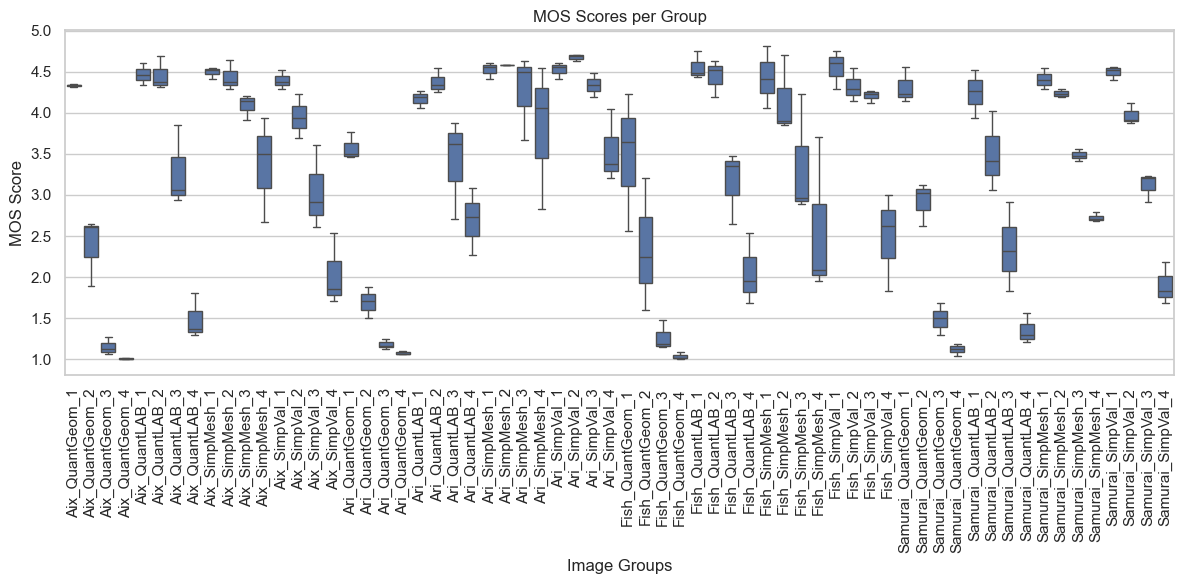

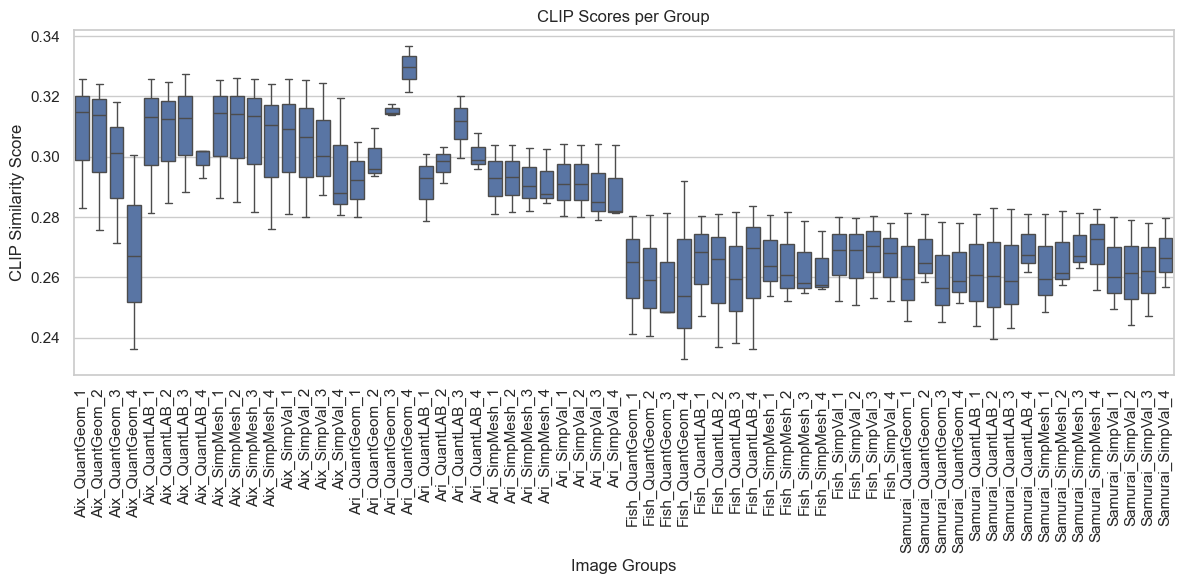

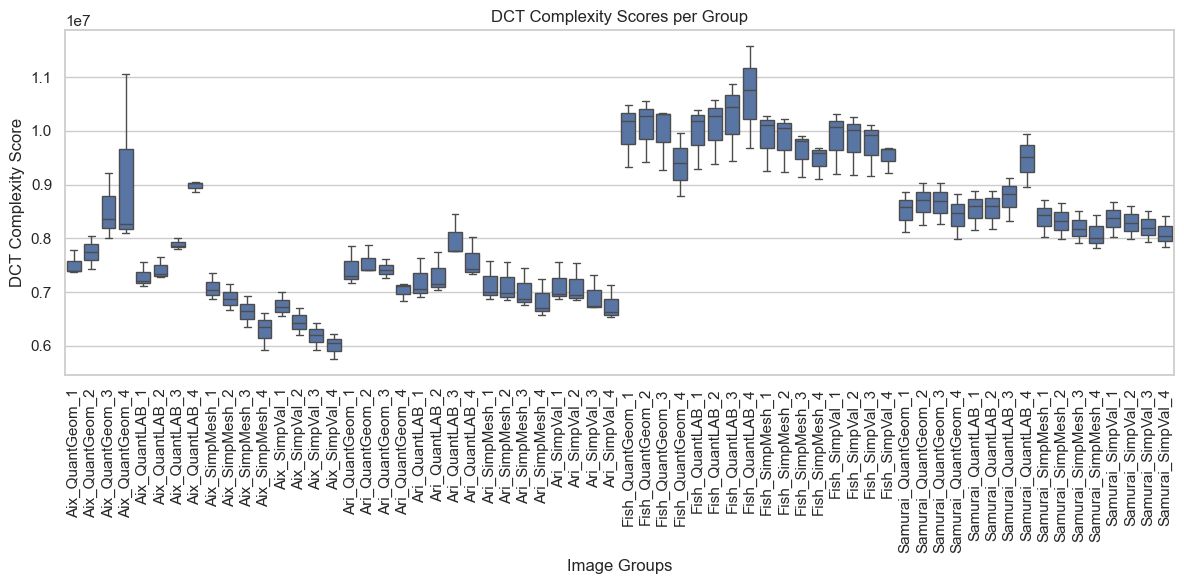

R² value between CLIP and DCT scores: 0.3221


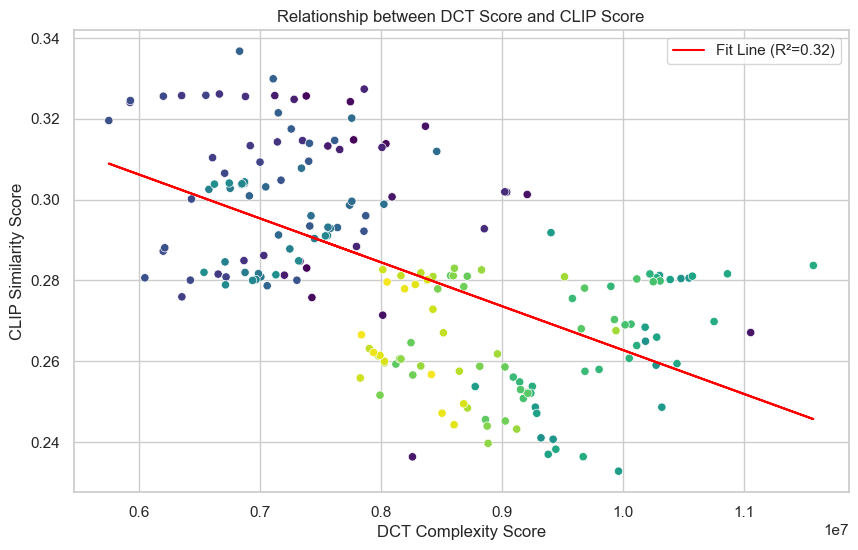

In [28]:
# Define the path to your image directory
image_dir = r'C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\Final_VertexColor_DB\Stimuli_snapshots'

# Initialize the grouped_images dictionary
grouped_images = defaultdict(list)

# Traverse the directory and group images
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        filepath = os.path.join(image_dir, filename)
        # Remove the file extension
        name_part = os.path.splitext(filename)[0]
        # Split the filename into its components
        parts = name_part.split('_')
        # Extract the group name (excluding the perspective)
        group_name = '_'.join(parts[:-1])
        # Add the image path to the corresponding group
        grouped_images[group_name].append(filepath)

# Load your DataFrame (adjust the path to your CSV file)
df = pd.read_csv(r'C:\Users\AMD\Downloads\CLIPLossOptimization\CLIPLossOptimization\All_Stimuli_MOS_and_MLE.csv')

# Load the CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Initialize a DataFrame to collect all data
data_list = []

# Process each group
for group_name, image_paths in grouped_images.items():
    print(f"Processing Group {group_name}:")

    for path in image_paths:
        print(f"  {path}")
        extracted_name = os.path.splitext(os.path.basename(path))[0]

        # MOS Score
        matching_rows = df[df['Stimuli'].str.startswith(extracted_name)]
        if matching_rows.empty:
            print(f"No matching rows found for {extracted_name} in DataFrame.")
            continue

        try:
            mos_r = matching_rows[matching_rows['Stimuli'].str.endswith('_R')]['MOS'].values[0]
            mos_z = matching_rows[matching_rows['Stimuli'].str.endswith('_Z')]['MOS'].values[0]
            avg_mos = (mos_r + mos_z) / 2
        except IndexError:
            print(f"MOS values not found for {extracted_name}.")
            continue

        # DCT Complexity Score
        image_array = imread(path, as_gray=False)

        # Convert image to grayscale if it's RGB
        if image_array.ndim == 3:
            image_gray = image_array.mean(axis=2)
        else:
            image_gray = image_array

        # Compute 2D DCT of the image
        dct_coefficients = dct(dct(image_gray.T, norm='ortho').T, norm='ortho')
        # Exclude the DC component
        dct_coefficients[0, 0] = 0
        # Compute the sum of absolute DCT coefficients as complexity measure
        dct_score = np.sum(np.abs(dct_coefficients))

        # CLIP Score
        # Convert to PIL Image for CLIP preprocessing
        pil_image = Image.open(path)

        # Preprocess the image
        image_input = preprocess(pil_image).unsqueeze(0).to(device)

        # Get text input
        text_from_row = matching_rows[matching_rows['Stimuli'].str.endswith('_R')]['Source_model'].values[0]
        text_input = clip.tokenize([text_from_row]).to(device)

        # Get image and text features
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_input)

            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate similarity
            similarity_score = (image_features @ text_features.T).squeeze().item()
            print(f"CLIP score: {similarity_score}")

        # Append the data to the list
        data_list.append({
            'Group': group_name,
            'Image': extracted_name,
            'MOS': avg_mos,
            'CLIP': similarity_score,
            'DCT': dct_score
        })

# Create a DataFrame from the collected data
df_scores = pd.DataFrame(data_list)

# Plotting the scores using seaborn for better aesthetics
sns.set(style='whitegrid')

# Plot MOS Scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='MOS', data=df_scores)
plt.title('MOS Scores per Group')
plt.xlabel('Image Groups')
plt.ylabel('MOS Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot CLIP Scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='CLIP', data=df_scores)
plt.title('CLIP Scores per Group')
plt.xlabel('Image Groups')
plt.ylabel('CLIP Similarity Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot DCT Scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='DCT', data=df_scores)
plt.title('DCT Complexity Scores per Group')
plt.xlabel('Image Groups')
plt.ylabel('DCT Complexity Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate the R² value between CLIP and DCT scores across all data points
X = df_scores['DCT'].values.reshape(-1, 1)
y = df_scores['CLIP'].values

# Create and fit the model
model_lr = LinearRegression()
model_lr.fit(X, y)
y_pred = model_lr.predict(X)

# Calculate R²
r2 = r2_score(y, y_pred)
print(f"R² value between CLIP and DCT scores: {r2:.4f}")

# Plot the regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DCT', y='CLIP', data=df_scores, hue='Group', palette='viridis', legend=False)
plt.plot(df_scores['DCT'], y_pred, color='red', label=f'Fit Line (R²={r2:.2f})')
plt.title('Relationship between DCT Score and CLIP Score')
plt.xlabel('DCT Complexity Score')
plt.ylabel('CLIP Similarity Score')
plt.legend()
plt.grid(True)
plt.show()
